# 03_Modeling (NumPy Machine Learning)

Notebook này thực hiện toàn bộ pipeline huấn luyện mô hình Logistic Regression

- Chuẩn hóa dữ liệu **(Z_score)**
- Chia tập **train/test**
- Giải quyết imbalanced với **SMOTE (Oversampling)**
- Huấn luyện mô hình **LogisticRegression**
- Đánh giá mô hình **(Accuracy, Precision, Recall,F1-score)**
- Confusion Matrix
- Loss Curve
- Feature Importance
- Cross-val-score


## Cài đặt và import thư viện , module cần thiết

In [1]:
import sys 
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from models import (
    MyLogisticRegression,
    train_test_split_numpy,
    standard_scaler_fit_transform,
    smote_numpy,
    train_and_evaluate,
    feature_importance_from_weights,
    precision_recall_curve_manual,
    auc_average_precision,
    cross_val_score_numpy,
    standard_scaler_transform)

## 1. Load Dữ Liệu 

Vì ở phần `02_preprocessing` tôi đã tạo ra X,y cho 03_modeling rồi.

- `X_full.npy` — toàn bộ các feature đã log transform + encode + chuẩn hóa dạng raw
- `y_full.npy` — biến mục tiêu (0 = Existing, 1 = Attrited)

In [2]:
X_full = np.load('../data/processed/X_full.npy')
y_full = np.load('../data/processed/y_full.npy')

print('Shape X: ',X_full.shape)
print('Shape y: ',y_full.shape)
print("Positive rate (Churn):", y_full.mean())

Shape X:  (10127, 32)
Shape y:  (10127,)
Positive rate (Churn): 0.1606596227905599


## 2. Train/Test split (Tỷ lệ 80/20)
- **80%**: là phần được giữ để mô hình học
- **20%**: là phần được giữ để mô hình test

In [3]:
X_train,X_test,y_train,y_test = train_test_split_numpy(X_full,y_full,test_size= 0.2)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(8101, 32) (2026, 32)
(8101,) (2026,)


## 3. Standard Scaler (Z_score scaler)
Các feature numeric sau khi log transform cần được chuẩn hóa để mô hình hội tụ nhanh hơn.

In [4]:
X_train_scaled, mean, std = standard_scaler_fit_transform(X_train) 
X_test_scaled = standard_scaler_transform(X_test, mean, std) 
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(8101, 32)
(2026, 32)


## 4. SMOTE 
Giúp cân bằng lại **class imbalance** — quan trọng với bài toán **churn (minority = attrited).**

In [5]:
X_train_sm, y_train_sm = smote_numpy(X_train_scaled, y_train, minority_class=1, k=5, amount=1.0)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_sm))

Before SMOTE: [6795 1306]
After SMOTE: [6795 2612]


## 5. Train Logistic Regression (NumPy)

Dùng chính **class MyLogisticRegression** để huấn luyện mô hình **(đã viết trong file models.py)**


In [6]:
model = MyLogisticRegression(lr=0.001,epochs = 1500, batch_size = 64,l2 = 0.0,verbose = True)

res = train_and_evaluate(model,X_train_sm,y_train_sm,X_test_scaled,y_test)

Epoch 0 | Loss = 0.6715
Epoch 50 | Loss = 0.3700
Epoch 100 | Loss = 0.3205
Epoch 150 | Loss = 0.3005
Epoch 200 | Loss = 0.2899
Epoch 250 | Loss = 0.2836
Epoch 300 | Loss = 0.2795
Epoch 350 | Loss = 0.2768
Epoch 400 | Loss = 0.2748
Epoch 450 | Loss = 0.2734
Epoch 500 | Loss = 0.2724
Epoch 550 | Loss = 0.2716
Epoch 600 | Loss = 0.2710
Epoch 650 | Loss = 0.2706
Epoch 700 | Loss = 0.2702
Epoch 750 | Loss = 0.2699
Epoch 800 | Loss = 0.2697
Epoch 850 | Loss = 0.2696
Epoch 900 | Loss = 0.2694
Epoch 950 | Loss = 0.2693
Epoch 1000 | Loss = 0.2692
Epoch 1050 | Loss = 0.2692
Epoch 1100 | Loss = 0.2691
Epoch 1150 | Loss = 0.2691
Epoch 1200 | Loss = 0.2690
Epoch 1250 | Loss = 0.2690
Epoch 1300 | Loss = 0.2690
Epoch 1350 | Loss = 0.2690
Epoch 1400 | Loss = 0.2689
Epoch 1450 | Loss = 0.2689


## 6. Hiệu năng mô hình

In [7]:
print("Accuracy:", res["accuracy"])
print("Precision:", res["precision"])
print("Recall:", res["recall"])
print("F1-score:", res["f1"])
print("\nConfusion matrix:\n", res["confusion_matrix"])

Accuracy: 0.8696939782823297
Precision: 0.5599999999999998
Recall: 0.8286604361370714
F1-score: 0.6683417085422321

Confusion matrix:
 [[1496  209]
 [  55  266]]


## 7. Loss Curve – Kiểm tra quá trình hội tụ


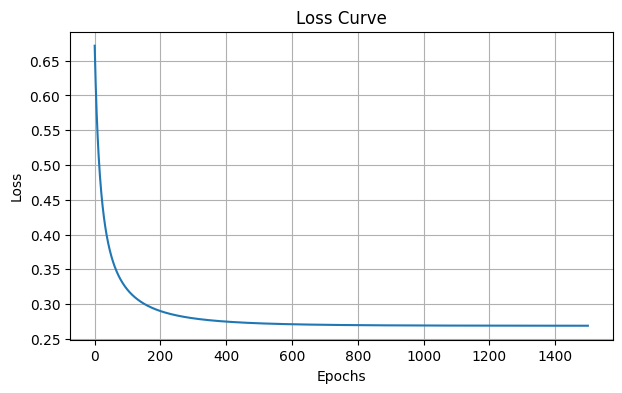

In [8]:
plt.figure(figsize=(7,4))
plt.plot(res["loss_history"])
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## 8. Confusion Matrix Visualization

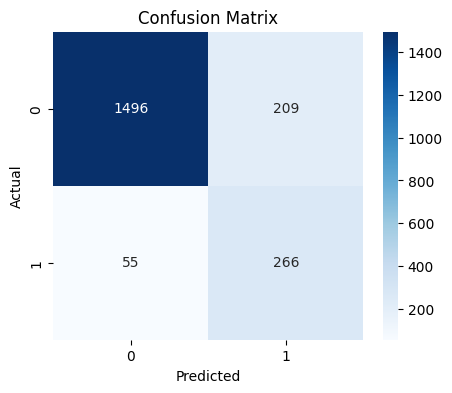

In [9]:
plt.figure(figsize=(5,4))
sns.heatmap(res["confusion_matrix"], annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 9. Precision–Recall Curve + AUC 

PR-AUC **rất quan trọng** trong churn vì:

- Class imbalance
- PR phản ánh khả năng phát hiện khách hàng sắp rời bỏ
- Luôn tốt hơn ROC-AUC trong các bài toán unbalanced.


In [10]:
y_proba = res["y_pred_proba"]

thresholds, precisions, recalls = precision_recall_curve_manual(y_test, y_proba)
ap = auc_average_precision(recalls, precisions)

print("Average Precision (PR-AUC):", ap)

Average Precision (PR-AUC): 0.7600784038029673


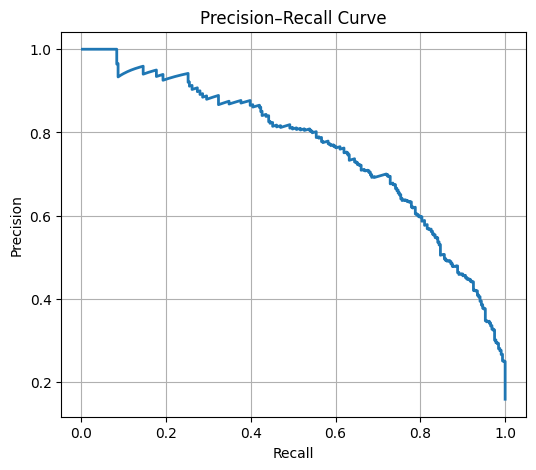

In [11]:
plt.figure(figsize=(6,5))
plt.plot(recalls, precisions, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()


## 10. K-fold Cross Validation (NumPy)

Đánh giá độ ổn định của mô hình.

In [12]:
cv_results = cross_val_score_numpy(MyLogisticRegression, X_full, y_full, k=5, lr=0.15, epochs=2000)

cv_results

{'mean_acc': 0.8803203782920794,
 'mean_precision': 0.5921394490263442,
 'mean_recall': 0.8209112129074482,
 'mean_f1': 0.6878235745287784,
 'acc_list': [np.float64(0.8840078973346496),
  np.float64(0.8721618953603159),
  np.float64(0.8819753086419753),
  np.float64(0.8849382716049383),
  np.float64(0.8785185185185185)],
 'precision_list': [np.float64(0.6050228310502281),
  np.float64(0.5824175824175822),
  np.float64(0.5780219780219779),
  np.float64(0.6106194690265485),
  np.float64(0.5846153846153844)],
 'recall_list': [np.float64(0.8103975535168193),
  np.float64(0.7934131736526944),
  np.float64(0.8483870967741932),
  np.float64(0.8288288288288286),
  np.float64(0.8235294117647056)],
 'f1_list': [np.float64(0.6928104575158501),
  np.float64(0.6717363751579398),
  np.float64(0.6875816993459228),
  np.float64(0.7031847133753074),
  np.float64(0.6838046272488715)]}

## Tổng kết và đánh giá mô hình 
- Bởi vì mô hình bị mất cân bằng nên điều chỉnh ngưỡng phù hợp là `0.3` thì **recall ổn đinh** (`>80%`)
- Ở đây, ta sẽ sử dụng **recall** metric để đánh giá mô hình
  - Bởi vì **Recall** càng cao có nghĩa là ít khách hàng bị bỏ sót
  - Chúng ta sẽ bắt được khách hàng có khả năng rời bỏ bằng cách tăng **Recall** giảm ngưỡng xuống, theo tiêu chí **Bắt nhầm còn hơn bỏ sót** , người nào có dấu hiệu thì chúng ta liền bắt được, ít bỏ sót hơn
- **Confusion matrix**
  - **True Negative (TN)**: 1496 - Dự đoán đúng khách hàng ở lại
  - **False Positive (FP)**: 209 - Cảnh báo sai (tốn chi phí marketing)
  - **True Positive (TP)**: 266 - Dự đoán đúng khách hàng rời đi thật
  - **False Negative (FN)**: 55 - Bỏ sót khách hàng rời đi thật
- **ƯU ĐIỂM NỔI BẬT**:
  - **Recall cao (82,4%)**:
    - Phát hiện được `82,4%` khách hàng **thực sự rời đi.**
    - Chỉ bỏ sót `55` khách hàng
  - **Giảm thiểu tổn thất kinh doanh**: Với recall cao , ngân hàng có cơ hội giữ chân được nhiều khách hàng thực sự có ý định rời đi
  - **Đường cong loss** giảm ổn định và hội tụ , chứng tỏ mô hình được train tốt
- **Insights**:
  - **Ưu tiên recall** phù hợp với chiến lược kinh doanh: `Giữ chân khách hàng quan trọng hơn`
  - **Mô hình** hiện tại đang tối ưu cho việc mất khách hàng 